In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [4]:
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

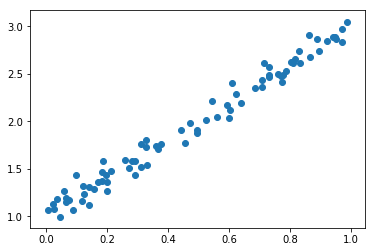

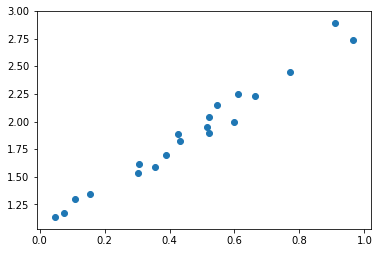

In [6]:
plt.scatter(x_train, y_train)
plt.show()

plt.scatter(x_val, y_val)
plt.show()

In [18]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[0.80119529] [0.04511107]
[1.02354075] [1.96896447]


In [21]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


In [55]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)
print(a.type(), b.type())

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(a, b)
print(a.type(), b.type())
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)
print(a.type(), b.type())

tensor([0.3901], requires_grad=True) tensor([1.4410], requires_grad=True)
torch.FloatTensor torch.FloatTensor
tensor([1.3630], requires_grad=True) tensor([0.5693], requires_grad=True)
torch.FloatTensor torch.FloatTensor
tensor([1.9089], requires_grad=True) tensor([1.6918], requires_grad=True)
torch.FloatTensor torch.FloatTensor


In [56]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


In [76]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)


lr = 1e-1
n_epochs = 1000


# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    # print(a.grad)
    # print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    
    # # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    # a.grad.zero_()
    # b.grad.zero_()

    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In [65]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()


In [77]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In [78]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [81]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


In [82]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

In [83]:
[*LayerLinearRegression().parameters()]

[Parameter containing:
 tensor([[-0.2191]], requires_grad=True), Parameter containing:
 tensor([0.2018], requires_grad=True)]

In [84]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


In [87]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


In [89]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [90]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [91]:
losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('a', tensor([1.0178])), ('b', tensor([1.9473]))])
